In [1]:
%matplotlib inline


# Digital Estimation

Converting a stream of control signals into a estimate samples.


In [2]:
from cbadc.utilities import compute_power_spectral_density
import matplotlib.pyplot as plt
from cbadc.utilities import read_byte_stream_from_file, \
    byte_stream_2_control_signal
from cbadc.utilities import random_control_signal
from cbadc.analog_system import AnalogSystem
from cbadc.digital_control import DigitalControl
from cbadc.digital_estimator import DigitalEstimator, FIRFilter
import cbadc
import numpy as np
from hadamard_pcb import *
from tqdm import tqdm
plt.rcParams['figure.figsize'] = [6.40*2.5, 6.40 * 1.5]

## Setting up the Analog System and Digital Control



In [3]:
# pcb = pcb_version_A
pcb = pcb_version_B

# export parameters for later use
N = pcb.AS.N
M = pcb.DC.M
T = pcb.DC.T

# Instantiate a Hadamard analog system.
analog_system = pcb.AS

# print the analog system such that we can verify it being correctly initalized.
print(analog_system, '\n')

# Initialize the digital control.
digital_control = pcb.DC
# print the digital control to verify proper initialization.
print(digital_control)

The analog system is parameterized as:
A =
[[ 134831.14556317   44943.71518772   44943.71518772  -44943.71518772]
 [ -44943.71518772 -134831.14556317   44943.71518772  -44943.71518772]
 [ -44943.71518772   44943.71518772   44943.71518772  134831.14556317]
 [ -44943.71518772   44943.71518772 -134831.14556317  -44943.71518772]],
B =
[[-187055.7426113]
 [-187055.7426113]
 [-187055.7426113]
 [-187055.7426113]],
CT = 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]],
Gamma =
[[ 233819.67826412  233819.67826412  233819.67826412  233819.67826412
  -233819.67826412      -0.              -0.              -0.        ]
 [ 233819.67826412 -233819.67826412  233819.67826412 -233819.67826412
       -0.         -233819.67826412      -0.              -0.        ]
 [ 233819.67826412  233819.67826412 -233819.67826412 -233819.67826412
       -0.              -0.         -233819.67826412      -0.        ]
 [ 233819.67826412 -233819.67826412 -233819.67826412  233819.67826412
       -0.          

In [4]:
OSR = 1 << 5
omega_3dB = 2 * np.pi / (2 * T * OSR)
## Anti-aliasing filter
wp = omega_3dB
ws = omega_3dB * 2 
gpass = 0.1
gstop = 120
analog_system = cbadc.analog_system.chain([cbadc.analog_system.IIRDesign(wp, ws, gpass, gstop, ftype="ellip"), analog_system])
eta2 = np.linalg.norm(analog_system.transfer_function_matrix(np.array([omega_3dB ])))**2
print(f"OSR = {OSR}, omega_3dB = {omega_3dB} [rad/s], {omega_3dB/(2 * np.pi)} [Hz], eta2 = {eta2}")

OSR = 32, omega_3dB = 98174.77042468105 [rad/s], 15625.000000000002 [Hz], eta2 = 756.360809419462


In [5]:
# downsampling=OSR
downsampling=1 << 0

## Loading Control Signal from File

Next, we will load an actual control signal to demonstrate the digital
estimator's capabilities. To this end, we will use the
`sinusodial_simulation.adc` file that was produced in
:doc:`./plot_b_simulate_a_control_bounded_adc`.

The control signal file is encoded as raw binary data so to unpack it
correctly we will use the :func:`cbadc.utilities.read_byte_stream_from_file`
and :func:`cbadc.utilities.byte_stream_2_control_signal` functions.



In [6]:
measurement_list = []
measurement_list.append( {
    'name': 'HP-33120',
    'path': 'hp_33120a.dat'
})
measurement_list.append( {
    'name': 'DS360',
    'path': 'srs_ds360.dat'
})
measurement_list.append( {
    'name': '500mV',
    'path': '500mV.dat'
})
measurement_list.append( {
    'name': '5mV',
    'path': '5mV.dat'
})
measurement_list.append( {
    'name': '5uV',
    'path': '5uV.dat'
})
measurement_list.append( {
    'name': 'cable',
    'path': 'cable.dat'
})
measurement_list.append( {
    'name': 'short',
    'path': 'short.dat'
})

In [7]:
for mesh in measurement_list:
    mesh['control_signal'] = byte_stream_2_control_signal(read_byte_stream_from_file(mesh['path'],M), M)

## Instantiate filters

In [8]:
K1 = 1 << 11
K2 = 1 << 11
stop_after_number_of_iterations = 1000000
size = stop_after_number_of_iterations // downsampling

for mesh in measurement_list:
    mesh['u_hat'] = np.zeros(size)
    mesh['digital_estimator'] = FIRFilter(
        analog_system, digital_control,
        eta2,
        K1,
        K2,
        downsample=downsampling,
#         offset = np.array([0.001739750646516668])
    )
    mesh['digital_estimator'](mesh['control_signal'])

## Impulse responses

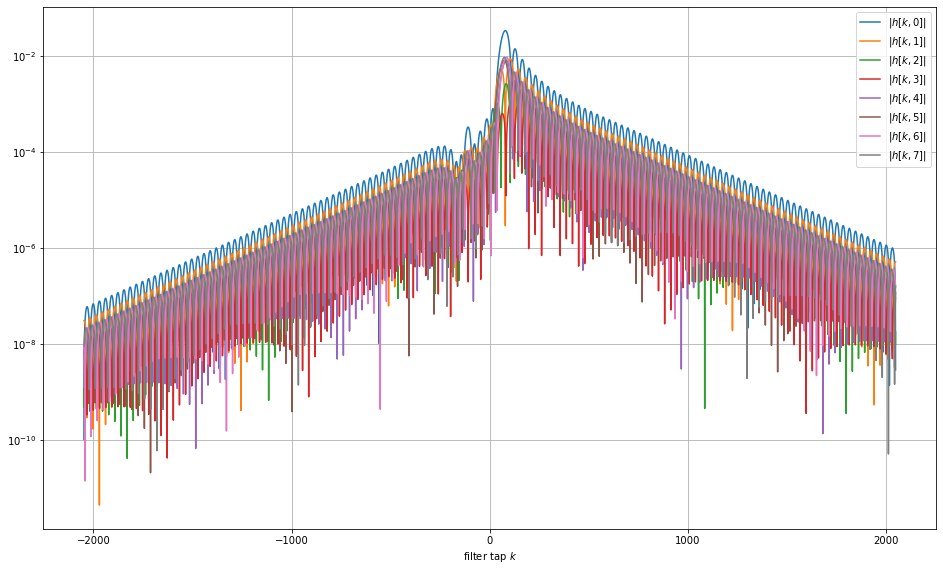

In [9]:
digital_estimator = measurement_list[-1]['digital_estimator']
impulse_response = np.abs(np.array(digital_estimator.h[0, :, :]))
plt.figure()
for m in range(digital_estimator.analog_system.M):
    plt.semilogy(np.arange(-K1, K2), impulse_response[:, m], label=f"$|h[k,{m}]|$")
plt.legend()
plt.xlabel('filter tap $k$')
plt.grid(which='both')

## STF and NTF

Text(0.5, 1.0, 'Signal and noise transfer functions')

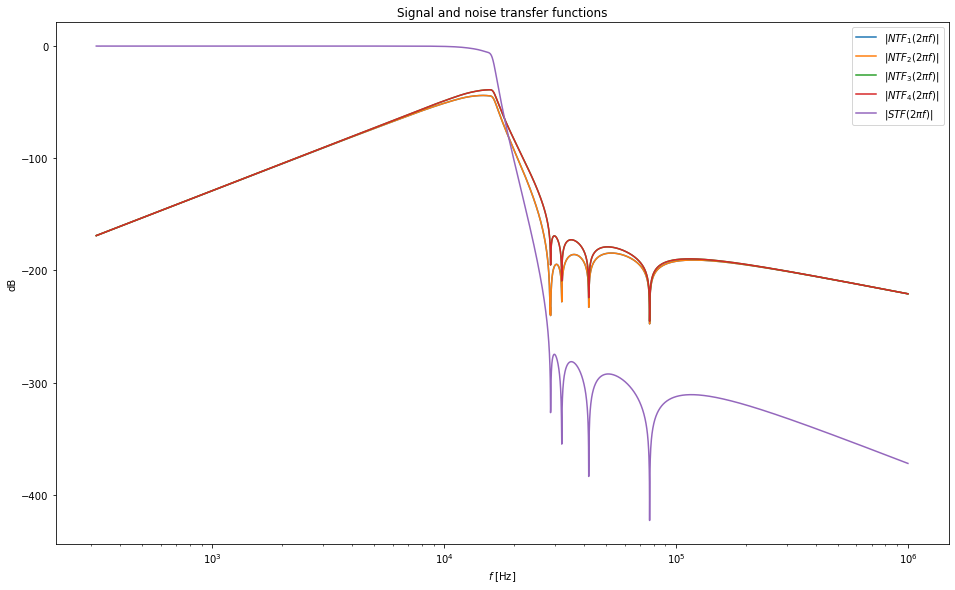

In [10]:
omega = 2 * np.pi * np.logspace(2.5,6, 5000)
two_pi = 2 * np.pi

ntf = digital_estimator.noise_transfer_function(omega)
stf = digital_estimator.signal_transfer_function(omega)

plt.figure()
for n in range(digital_estimator.analog_system.N_tilde):
    plt.semilogx(omega / two_pi, 20 * np.log10(np.abs(ntf[0, n, :]).flatten()), label=f"$|NTF_{n + 1}(2 \pi f)|$")
plt.semilogx(omega / two_pi, 20 * np.log10(np.abs(stf.flatten())), label="$|STF(2 \pi f)|$")
    
plt.legend()
plt.xlabel("$f$ [Hz]")
plt.ylabel('dB')
plt.title("Signal and noise transfer functions")


## Estimating the input

Fortunately, we used the same
analog system and digital controls as in this example so




In [11]:
for mesh in measurement_list:
    for index in tqdm(range(size)):
        mesh['u_hat'][index] = next(mesh['digital_estimator'])

100%|██████████| 1000000/1000000 [01:58<00:00, 8455.60it/s]


<ipython-input-12-e384cf33bbe6>:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


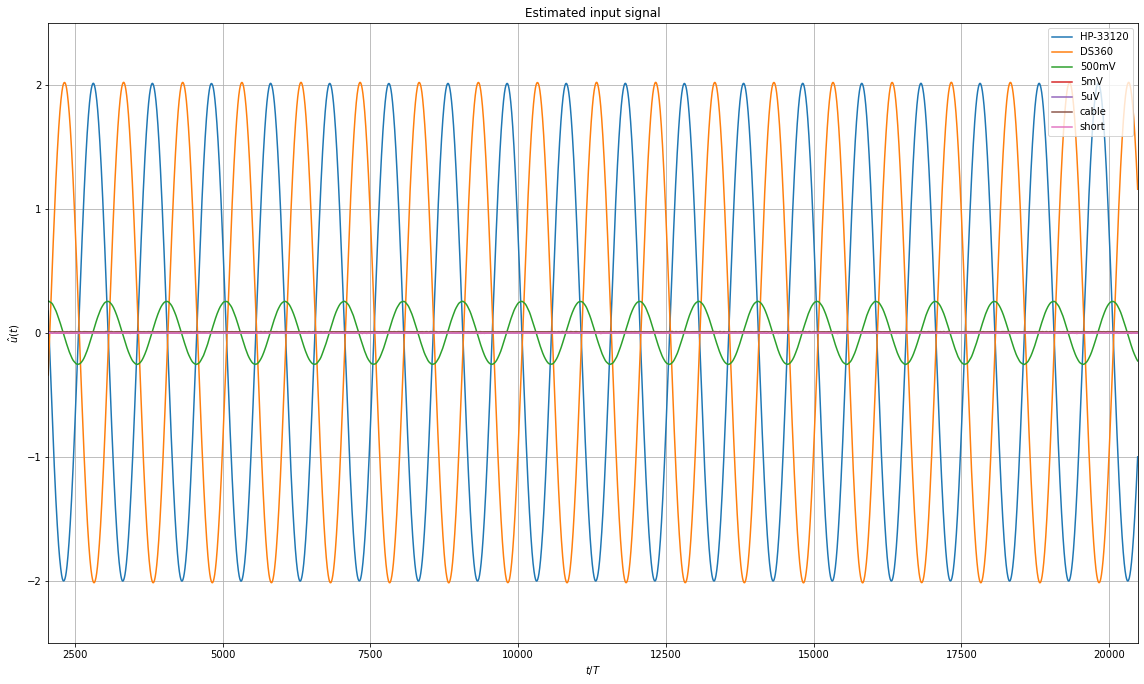

In [12]:
plt.rcParams['figure.figsize'] = [6.40*2.5, 6.40 * 1.5]
t = np.arange(size)
for mesh in measurement_list[:]:
    plt.plot(t, mesh['u_hat'], label=mesh['name'])
plt.xlabel('$t / T$')
plt.ylabel('$\hat{u}(t)$')
plt.title("Estimated input signal")
plt.legend()
plt.grid()
plt.xlim((K2, 10 * K2))
plt.ylim((-2.5, 2.5))
# plt.ylim((-0.03, 0.03))
plt.tight_layout()

In [13]:
print(f"resulting sampling rate: {np.round(1e-3/(downsampling * T))} [kHz]")

resulting sampling rate: 1000.0 [kHz]


## Plotting the PSD

As is typical for delta-sigma modulators, we often visualize the performance
of the estimate by plotting the power spectral density (PSD).



## Plotting signals with Sinusoid

In [14]:
psd_start_i = K2 // downsampling
psd_len = size // downsampling
psd_stop_i = psd_start_i + psd_len

fs = 1/(T * downsampling)

for mesh in measurement_list:
    f, psd = compute_power_spectral_density(mesh['u_hat'][psd_start_i:psd_stop_i], nperseg = psd_len, fs = fs)
    mesh['psd'] = psd
    mesh['f'] = f
    mesh['psdDB'] = 10 * np.log10(psd)


/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1000000 is greater than input length  = 997952, using nperseg = 997952
  warnings.warn('nperseg = {0:d} is greater than input length '


In [15]:
for mesh in measurement_list[:]:
    signal_index = cbadc.utilities.find_sinusoidal(mesh['psd'], 50)        
    if (signal_index == mesh['psd'].size).any():
        signal_index = np.arange(10)
    noise_index = np.ones(mesh['psd'].size, dtype=bool)
    noise_index[signal_index] = False
    noise_index[0:2] = False
    OSR=128
    noise_index[stop_after_number_of_iterations // OSR:] = False
    
    
    # print(signal_index, noise_index)

    noise = np.sum(psd[noise_index])
    signal = np.sum(psd[signal_index])

    # print(f, 1.0/OSR, 0.5/OSR)


    res = cbadc.utilities.snr_spectrum_computation_extended(mesh['psd'], signal_index, noise_index, fs = fs)
    SNR = 10 * np.log10(res['snr'])
    mesh["SNR"] = SNR
    mesh["ENOB"] = np.round((SNR - 1.76) / 6.02, 1)
    mesh["s_rms"] = res['signal_rms']
    mesh["n_rms"] = res['noise_rms']
    print(f"{mesh['name']}")
    print(f"SNR {round(mesh['SNR'], 2)} dB, ENOB {mesh['ENOB']}, Signal RMS {np.round(mesh['s_rms'],1)} V, {np.round(20 * np.log10(mesh['s_rms']), 1)} dB, Noise RMS = {np.round(mesh['n_rms'], 1)}, {np.round(20 * np.log10(mesh['n_rms']),1)} dB\n")
    


HP-33120
SNR 71.29 dB, ENOB 11.6, Signal RMS 2.6 V, 8.4 dB, Noise RMS = 0.0, -65.2 dB

DS360
SNR 74.19 dB, ENOB 12.0, Signal RMS 2.7 V, 8.5 dB, Noise RMS = 0.0, -68.1 dB

500mV
SNR 66.15 dB, ENOB 10.7, Signal RMS 0.3 V, -9.5 dB, Noise RMS = 0.0, -78.1 dB

5mV
SNR 23.7 dB, ENOB 3.6, Signal RMS 0.0 V, -49.5 dB, Noise RMS = 0.0, -75.5 dB

5uV
SNR -7.77 dB, ENOB -1.6, Signal RMS 0.0 V, -80.5 dB, Noise RMS = 0.0, -75.1 dB

cable
SNR 1.88 dB, ENOB 0.0, Signal RMS 0.0 V, -73.4 dB, Noise RMS = 0.0, -77.7 dB

short
SNR 1.34 dB, ENOB -0.1, Signal RMS 0.0 V, -96.1 dB, Noise RMS = 0.0, -99.8 dB



/opt/anaconda3/lib/python3.8/site-packages/cbadc/utilities.py:357: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if window == 'hanning':


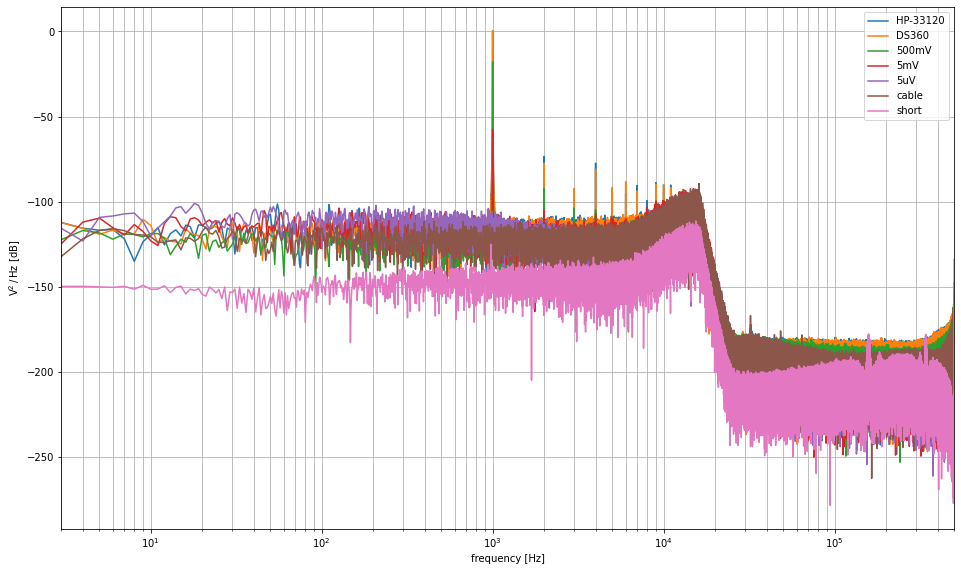

In [16]:
plt.figure()
for mesh in measurement_list[:]:
    plt.semilogx(mesh['f'], mesh['psdDB'], label=mesh["name"])

plt.xlabel('frequency [Hz]')
plt.ylabel('$ \mathrm{V}^2 \, / \, \mathrm{Hz}$ [dB]')
plt.xlim((3, f[-1]))
plt.legend()
# plt.ylim((-150,-50))
plt.grid(which='both')

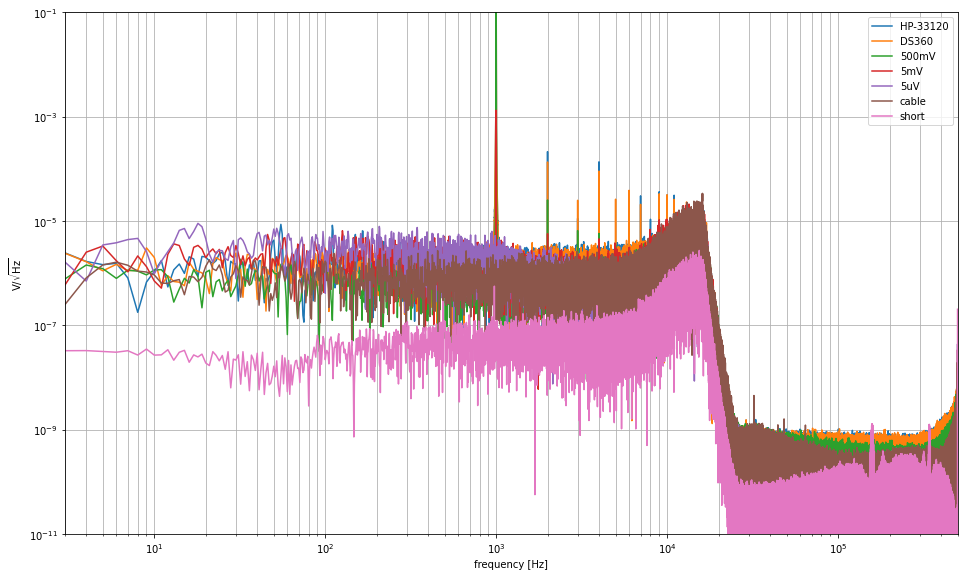

In [17]:
# V/sqrt(Hz)
plt.figure()

omega = 2 * np.pi * np.logspace(2.5,6)
two_pi = 2 * np.pi

for mesh in measurement_list[:]:
    plt.loglog(mesh['f'], np.sqrt(mesh['psd']), label=mesh["name"])

plt.xlabel('frequency [Hz]')
plt.ylabel('$\mathrm{V}/\sqrt{\mathrm{Hz}}$')
plt.xlim((3, f[-1]))
plt.legend()
plt.ylim((1e-11,1e-1))
plt.grid(which='both')